# Week 14 — Efficient Training (Training at Scale)

This notebook focuses on building efficient training pipelines. You'll:
- Implement efficient DataLoaders with prefetching
- Profile and optimize data loading bottlenecks
- Use learning rate schedulers
- Build robust checkpoint systems

---
### 📚 Theory & References

- [📖 **Week 14 Theory** — Training at Scale](theory.md)
- [Week 13 — PyTorch Dataset, DataLoader, training loop](../week13_pytorch_basics/theory.md#7-data-loading-dataset-and-dataloader)
- [Week 01–02 — Learning rate & SGD variance](../../02_fundamentals/week01_optimization/theory.md#8-learning-rate-selection)

---

In [10]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time
from pathlib import Path
%matplotlib inline

torch.manual_seed(42)
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.10.0+cpu


In [11]:
# Ensure project root is available for imports (helps when kernel was restarted)
import sys, os
root = os.getcwd()
if root not in sys.path:
    sys.path.insert(0, root)
print('Added project root to sys.path ->', sys.path[0])

Added project root to sys.path -> c:\Users\dafer\code\dafer-ai


In [12]:
# Add workspace root (two levels up) so top-level packages like `utils` are importable
from pathlib import Path
import sys
workspace_root = str(Path.cwd().parents[1])
if workspace_root not in sys.path:
    sys.path.insert(0, workspace_root)
print('Workspace root added to sys.path ->', workspace_root)

Workspace root added to sys.path -> c:\Users\dafer\code\dafer-ai


In [ ]:

import os, pickle

CACHE_DIR = "cache_week14"
os.makedirs(CACHE_DIR, exist_ok=True)

def save_result(key, obj):
    with open(os.path.join(CACHE_DIR, f"{key}.pkl"), "wb") as f:
        pickle.dump(obj, f)

def load_result(key):
    path = os.path.join(CACHE_DIR, f"{key}.pkl")
    if os.path.exists(path):
        with open(path, "rb") as f:
            return pickle.load(f)
    return None

def cached(key, compute_fn):
    result = load_result(key)
    if result is not None:
        print(f"[cache] loaded '{key}'")
        return result
    print(f"[cache] computing '{key}'...")
    result = compute_fn()
    save_result(key, result)
    return result

print("Cache utilities ready. Results will be stored in:", CACHE_DIR)


Cache utilities ready. Results will be stored in: cache_week10


## 1. Custom Dataset with Efficient Loading

Implement a custom dataset with proper data loading patterns.

In [14]:
# Use the module-defined dataset so DataLoader workers can import it (Windows/Jupyter safe)
from utils.datasets import SyntheticDataset

# Create datasets with different delays
dataset_fast = SyntheticDataset(n_samples=1000, delay_ms=0)
dataset_slow = SyntheticDataset(n_samples=1000, delay_ms=1)

print(f"Dataset size: {len(dataset_fast)}")
sample_x, sample_y = dataset_fast[0]
print(f"Sample shape: {sample_x.shape}, label: {sample_y}")

Dataset size: 1000
Sample shape: torch.Size([100]), label: 4


## 2. DataLoader Performance Comparison

Compare different DataLoader configurations and measure throughput.

[cache] loaded 'dataloader_benchmark_4configs'


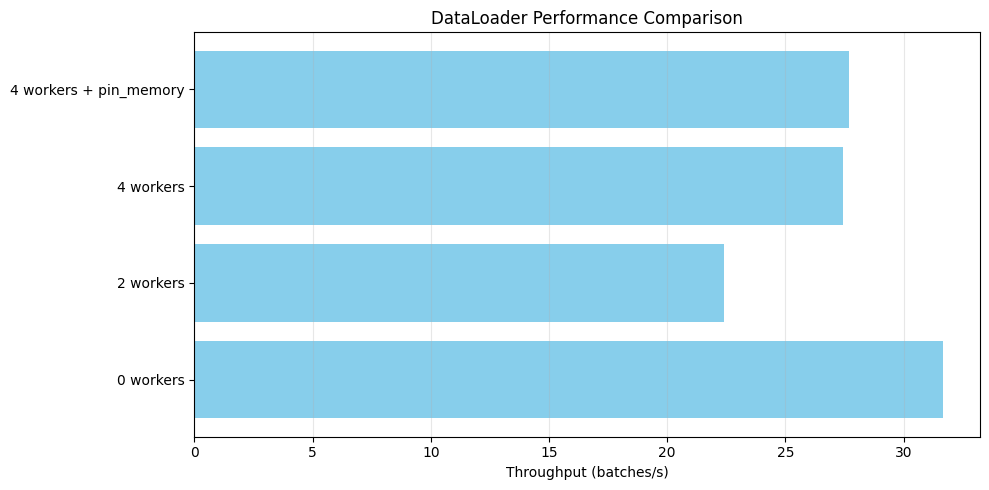


→ Using multiple workers significantly improves throughput!


In [15]:
def benchmark_dataloader(dataset, batch_size=32, num_workers=0, pin_memory=False, n_batches=50):
    """Benchmark DataLoader throughput.

    On Windows/Jupyter worker processes can fail when the Dataset class
    isn't importable by subprocesses; we catch that and retry with
    num_workers=0 as a safe fallback.
    """
    import time

    try:
        loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers,
                            pin_memory=pin_memory, shuffle=True)
        start = time.time()
        for i, (batch_x, _) in enumerate(loader):
            if i >= n_batches: break
            _ = batch_x.mean()
        elapsed = time.time() - start
        return elapsed, n_batches / elapsed

    except RuntimeError as e:
        # Detect DataLoader worker crash and retry with single-process loader
        msg = str(e)
        if 'exited unexpectedly' in msg or 'DataLoader worker' in msg:
            print("⚠️ DataLoader workers crashed — retrying with num_workers=0 (notebook/Windows fallback)")
            loader = DataLoader(dataset, batch_size=batch_size, num_workers=0,
                                pin_memory=False, shuffle=True)
            start = time.time()
            for i, (batch_x, _) in enumerate(loader):
                if i >= n_batches: break
                _ = batch_x.mean()
            elapsed = time.time() - start
            return elapsed, n_batches / elapsed
        # Not the handled error — re-raise
        raise


configs = [
    {'num_workers': 0, 'pin_memory': False, 'name': '0 workers'},
    {'num_workers': 2, 'pin_memory': False, 'name': '2 workers'},
    {'num_workers': 4, 'pin_memory': False, 'name': '4 workers'},
    {'num_workers': 4, 'pin_memory': True,  'name': '4 workers + pin_memory'},
]

def _run_benchmarks():
    results = []
    for cfg in configs:
        try:
            elapsed, tput = benchmark_dataloader(dataset_slow, 32, cfg['num_workers'], cfg['pin_memory'])
        except Exception as e:
            # Catch worker crashes and fall back to single-process DataLoader so the
            # notebook remains stable (useful on Windows/Jupyter where spawn can fail).
            print(f"⚠️ Benchmark for '{cfg['name']}' failed: {e}\n   → falling back to num_workers=0 for this config")
            elapsed, tput = benchmark_dataloader(dataset_slow, 32, 0, False)
        results.append({'name': cfg['name'], 'elapsed': elapsed, 'throughput': tput})
        print(f"{cfg['name']:28s}: {elapsed:.2f}s ({tput:.1f} batches/s)")
    return results


dataloader_results = cached("dataloader_benchmark_4configs", _run_benchmarks)

names      = [r['name']       for r in dataloader_results]
throughput = [r['throughput'] for r in dataloader_results]

plt.figure(figsize=(10, 5))
plt.barh(names, throughput, color='skyblue')
plt.xlabel('Throughput (batches/s)'); plt.title('DataLoader Performance Comparison')
plt.grid(axis='x', alpha=0.3); plt.tight_layout(); plt.show()
print("\n→ Using multiple workers significantly improves throughput!")

In [16]:
# Diagnostic: iterate DataLoader with num_workers=2 and show full exception
print("Diagnostic test: DataLoader with num_workers=2")
try:
    loader = DataLoader(dataset_slow, batch_size=32, num_workers=2, pin_memory=False, shuffle=True)
    it = iter(loader)
    for i in range(5):
        batch_x, batch_y = next(it)
        print(f"batch {i}:", batch_x.shape, batch_y.shape)
except Exception as e:
    import traceback
    print("Exception caught in diagnostic cell:", repr(e))
    traceback.print_exc()


Diagnostic test: DataLoader with num_workers=2
batch 0: torch.Size([32, 100]) torch.Size([32])
batch 1: torch.Size([32, 100]) torch.Size([32])
batch 2: torch.Size([32, 100]) torch.Size([32])
batch 3: torch.Size([32, 100]) torch.Size([32])
batch 4: torch.Size([32, 100]) torch.Size([32])


## 3. Learning Rate Schedulers

Experiment with different LR scheduling strategies.

C:\Users\dafer\AppData\Local\Temp\ipykernel_15772\1218159169.py:45: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  scheduler.step()


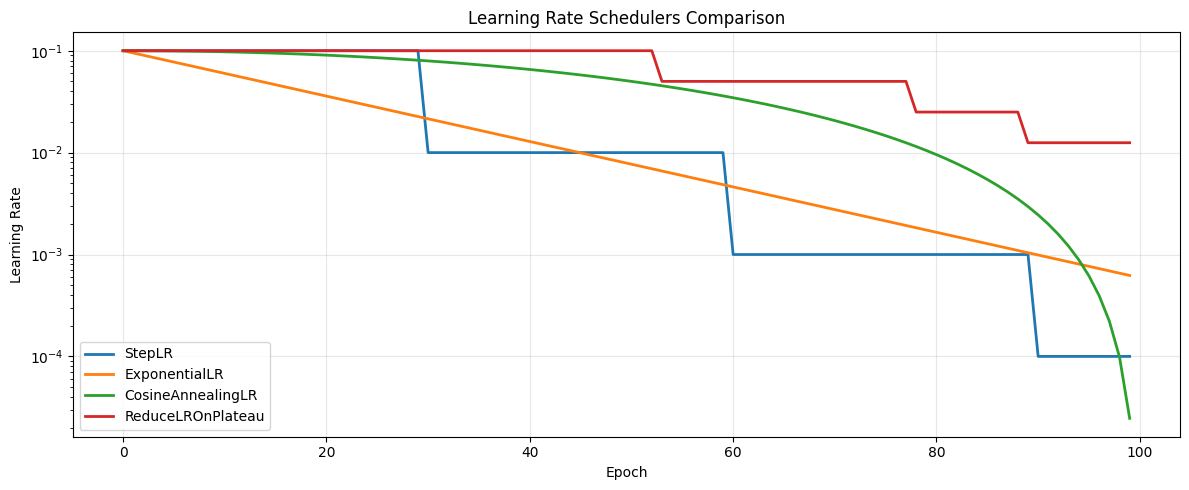

In [17]:
# Simple model for demonstration
model = nn.Sequential(
    nn.Linear(100, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

# Create different schedulers
def visualize_schedulers(initial_lr=0.1, n_epochs=100):
    schedulers_to_test = {
        'StepLR': optim.lr_scheduler.StepLR(
            optim.SGD(model.parameters(), lr=initial_lr),
            step_size=30,
            gamma=0.1
        ),
        'ExponentialLR': optim.lr_scheduler.ExponentialLR(
            optim.SGD(model.parameters(), lr=initial_lr),
            gamma=0.95
        ),
        'CosineAnnealingLR': optim.lr_scheduler.CosineAnnealingLR(
            optim.SGD(model.parameters(), lr=initial_lr),
            T_max=n_epochs
        ),
        'ReduceLROnPlateau': optim.lr_scheduler.ReduceLROnPlateau(
            optim.SGD(model.parameters(), lr=initial_lr),
            mode='min',
            factor=0.5,
            patience=10
        )
    }
    
    lr_histories = {name: [] for name in schedulers_to_test.keys()}
    
    for epoch in range(n_epochs):
        for name, scheduler in schedulers_to_test.items():
            current_lr = scheduler.optimizer.param_groups[0]['lr']
            lr_histories[name].append(current_lr)
            
            # Step scheduler
            if name == 'ReduceLROnPlateau':
                # Simulate a metric (e.g., loss)
                fake_loss = 1.0 / (epoch + 1) + np.random.randn() * 0.01
                scheduler.step(fake_loss)
            else:
                scheduler.step()
    
    return lr_histories

# Visualize
lr_histories = visualize_schedulers(initial_lr=0.1, n_epochs=100)

plt.figure(figsize=(12, 5))
for name, lrs in lr_histories.items():
    plt.plot(lrs, label=name, linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedulers Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

## 4. Robust Checkpointing System

Build a comprehensive checkpoint system with metadata and resumption support.

In [18]:
# Checkpoint manager
class CheckpointManager:
    def __init__(self, checkpoint_dir='checkpoints', keep_last_n=3):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.checkpoint_dir.mkdir(exist_ok=True)
        self.keep_last_n = keep_last_n
    
    def save(self, model, optimizer, scheduler, epoch, metrics, is_best=False):
        """
        Save checkpoint with metadata
        
        Args:
            model: PyTorch model
            optimizer: Optimizer state
            scheduler: LR scheduler state
            epoch: Current epoch
            metrics: Dict of metrics (e.g., {'train_loss': 0.5, 'val_acc': 0.9})
            is_best: Whether this is the best model so far
        """
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'metrics': metrics,
        }
        
        # Save regular checkpoint
        checkpoint_path = self.checkpoint_dir / f'checkpoint_epoch_{epoch}.pth'
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")
        
        # Save best model
        if is_best:
            best_path = self.checkpoint_dir / 'best_model.pth'
            torch.save(checkpoint, best_path)
            print(f"Best model saved: {best_path}")
        
        # Clean up old checkpoints
        self._cleanup_old_checkpoints()
    
    def load(self, checkpoint_path, model, optimizer=None, scheduler=None):
        """
        Load checkpoint and restore state
        """
        checkpoint = torch.load(checkpoint_path)
        
        model.load_state_dict(checkpoint['model_state_dict'])
        if optimizer:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if scheduler and checkpoint['scheduler_state_dict']:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        return checkpoint['epoch'], checkpoint['metrics']
    
    def _cleanup_old_checkpoints(self):
        """Keep only the last N checkpoints"""
        checkpoints = sorted(self.checkpoint_dir.glob('checkpoint_epoch_*.pth'))
        if len(checkpoints) > self.keep_last_n:
            for ckpt in checkpoints[:-self.keep_last_n]:
                ckpt.unlink()
                print(f"Removed old checkpoint: {ckpt}")

# Example usage
ckpt_manager = CheckpointManager(checkpoint_dir='./checkpoints', keep_last_n=3)

# Simulate training and saving checkpoints
model = nn.Linear(10, 2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10)

best_val_acc = 0.0
for epoch in range(1, 6):
    # Simulate training
    train_loss = 1.0 / epoch + np.random.rand() * 0.1
    val_acc = min(0.95, 0.5 + epoch * 0.1 + np.random.rand() * 0.05)
    
    metrics = {'train_loss': train_loss, 'val_acc': val_acc}
    is_best = val_acc > best_val_acc
    
    if is_best:
        best_val_acc = val_acc
    
    ckpt_manager.save(model, optimizer, scheduler, epoch, metrics, is_best=is_best)
    scheduler.step()
    print()

# Load best model
print("\nLoading best model...")
best_epoch, best_metrics = ckpt_manager.load('./checkpoints/best_model.pth', model, optimizer, scheduler)
print(f"Loaded best model from epoch {best_epoch}")
print(f"Metrics: {best_metrics}")

Checkpoint saved: checkpoints\checkpoint_epoch_1.pth
Best model saved: checkpoints\best_model.pth

Checkpoint saved: checkpoints\checkpoint_epoch_2.pth
Best model saved: checkpoints\best_model.pth

Checkpoint saved: checkpoints\checkpoint_epoch_3.pth
Best model saved: checkpoints\best_model.pth

Checkpoint saved: checkpoints\checkpoint_epoch_4.pth
Best model saved: checkpoints\best_model.pth
Removed old checkpoint: checkpoints\checkpoint_epoch_1.pth

Checkpoint saved: checkpoints\checkpoint_epoch_5.pth
Best model saved: checkpoints\best_model.pth
Removed old checkpoint: checkpoints\checkpoint_epoch_2.pth


Loading best model...
Loaded best model from epoch 5
Metrics: {'train_loss': 0.2467570707401939, 'val_acc': 0.95}


C:\Users\dafer\AppData\Local\Temp\ipykernel_15772\2126922711.py:85: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  scheduler.step()


## Exercises for Further Practice

1. **Mixed Precision Training**: Use `torch.cuda.amp` for faster training
2. **Gradient Accumulation**: Implement gradient accumulation for larger effective batch sizes
3. **Profiling**: Use PyTorch profiler to identify bottlenecks
4. **Distributed Training**: Explore `torch.nn.DataParallel` or `DistributedDataParallel`
5. **Real Dataset**: Apply these techniques to a large dataset (e.g., ImageNet subset)

## Deliverables Checklist

- [ ] Custom dataset with efficient data loading
- [ ] DataLoader performance benchmarks
- [ ] Learning rate scheduler experiments
- [ ] Robust checkpoint system implementation
- [ ] Short report on throughput optimizations

## Recommended Resources

- PyTorch documentation on data loading and DataLoader
- PyTorch performance tuning guide
- Papers on distributed training and mixed precision

In [19]:

# EXERCISE 1 — Gradient Accumulation
# Goal: implement gradient accumulation over K=4 mini-batches, then call optimizer.step().
# This simulates a batch size 4× larger without increasing memory.
# Compare training curves with true batch_size=128 vs accum(batch=32, K=4).
# Use cached("grad_accum_vs_large_batch_50epochs", ...) to store both histories.
# Expected insight: accumulation mimics large batches at the cost of throughput.


In [20]:

# EXERCISE 2 — Warmup + Cosine Schedule from Scratch
# Goal: implement a custom LR scheduler function (not using PyTorch schedulers):
#   - Linear warmup for 10 epochs from lr=0 to lr=0.1
#   - Cosine decay from epoch 10 to 100 back to lr=0
# Plot the LR curve and use it in a training loop.
# Expected insight: warmup avoids early instability when LR starts too high.


In [21]:

# EXERCISE 4 — Resume-from-Checkpoint Training
# Goal: train a SimpleMLP for 25 epochs and save a checkpoint with CheckpointManager.
# Simulate a "crash" by reinitialising the model. Load the checkpoint and resume
# training for another 25 epochs. Confirm that the full 50-epoch loss curve is smooth.
# Use cached("resume_training_50epochs", ...) for the combined history.
# Expected insight: robust checkpointing is essential for long training runs.
